## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 30 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.25, 0.5]
redice_lr_patient = [5, 8]


In [8]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, reduce_factor: 0.25, reduce_patient: 5
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
_________________________________________________________________
b

50000/50000 [==============================] - 7s 146us/step - loss: 1.7446 - accuracy: 0.3904 - val_loss: 1.8020 - val_accuracy: 0.3741
Epoch 6/30
50000/50000 [==============================] - 7s 146us/step - loss: 1.7004 - accuracy: 0.4053 - val_loss: 1.7480 - val_accuracy: 0.3872
Epoch 7/30
50000/50000 [==============================] - 7s 146us/step - loss: 1.6662 - accuracy: 0.4166 - val_loss: 1.7150 - val_accuracy: 0.3981
Epoch 8/30
50000/50000 [==============================] - 7s 148us/step - loss: 1.6366 - accuracy: 0.4272 - val_loss: 1.6882 - val_accuracy: 0.4102
Epoch 9/30
50000/50000 [==============================] - 7s 148us/step - loss: 1.6102 - accuracy: 0.4359 - val_loss: 1.6693 - val_accuracy: 0.4140
Epoch 10/30
50000/50000 [==============================] - 7s 146us/step - loss: 1.5886 - accuracy: 0.4450 - val_loss: 1.6505 - val_accuracy: 0.4234
Epoch 11/30
50000/50000 [==============================] - 7s 147us/step - loss: 1.5670 - accuracy: 0.4529 - val_loss: 1.6

Epoch 20/30
50000/50000 [==============================] - 7s 144us/step - loss: 1.4297 - accuracy: 0.5005 - val_loss: 1.5883 - val_accuracy: 0.4515
Epoch 21/30
50000/50000 [==============================] - 8s 150us/step - loss: 1.4187 - accuracy: 0.5053 - val_loss: 1.5796 - val_accuracy: 0.4529
Epoch 22/30
50000/50000 [==============================] - 7s 145us/step - loss: 1.4068 - accuracy: 0.5109 - val_loss: 1.5778 - val_accuracy: 0.4524
Epoch 23/30
50000/50000 [==============================] - 8s 150us/step - loss: 1.3970 - accuracy: 0.5133 - val_loss: 1.5698 - val_accuracy: 0.4588
Epoch 24/30
50000/50000 [==============================] - 7s 145us/step - loss: 1.3861 - accuracy: 0.5172 - val_loss: 1.5654 - val_accuracy: 0.4553
Epoch 25/30
50000/50000 [==============================] - 8s 150us/step - loss: 1.3755 - accuracy: 0.5210 - val_loss: 1.5652 - val_accuracy: 0.4590
Epoch 26/30
50000/50000 [==============================] - 7s 145us/step - loss: 1.3662 - accuracy: 0.5252

Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 8s 170us/step - loss: 1.7816 - accuracy: 0.3828 - val_loss: 2.2322 - val_accuracy: 0.2416
Epoch 2/30
50000/50000 [==============================] - 7s 150us/step - loss: 1.4883 - accuracy: 0.4745 - val_loss: 1.8377 - val_accuracy: 0.3416
Epoch 3/30
50000/50000 [==============================] - 8s 154us/step - loss: 1.3764 - accuracy: 0.5162 - val_loss: 1.7047 - val_accuracy: 0.3855
Epoch 4/30
50000/50000 [==============================] - 7s 150us/step - loss: 1.2900 - accuracy: 0.5444 - val_loss: 1.7243 - val_accuracy: 0.3798
Epoch 5/30
50000/50000 [==============================] - 8s 153us/step - loss: 1.2258 - accuracy: 0.5687 - val_loss: 1.7527 - val_accuracy: 0.3879
Epoch 6/30
50000/50000 [==============================] - 8s 151us/step - loss: 1.1638 - accuracy: 0.5903 - val_loss: 1.8243 - val_accuracy: 0.3903
Epoch 7/30
50000/50000 [==============================] - 8s 1

50000/50000 [==============================] - 8s 154us/step - loss: 1.7365 - accuracy: 0.3954 - val_loss: 1.7994 - val_accuracy: 0.3755
Epoch 14/30
50000/50000 [==============================] - 8s 151us/step - loss: 1.7228 - accuracy: 0.4012 - val_loss: 1.7951 - val_accuracy: 0.3804
Epoch 15/30
50000/50000 [==============================] - 8s 155us/step - loss: 1.7097 - accuracy: 0.4045 - val_loss: 1.7910 - val_accuracy: 0.3800
Epoch 16/30
50000/50000 [==============================] - 8s 151us/step - loss: 1.6988 - accuracy: 0.4090 - val_loss: 1.7858 - val_accuracy: 0.3815
Epoch 17/30
50000/50000 [==============================] - 8s 155us/step - loss: 1.6882 - accuracy: 0.4118 - val_loss: 1.7796 - val_accuracy: 0.3849
Epoch 18/30
50000/50000 [==============================] - 8s 152us/step - loss: 1.6782 - accuracy: 0.4154 - val_loss: 1.7730 - val_accuracy: 0.3892
Epoch 19/30
50000/50000 [==============================] - 8s 156us/step - loss: 1.6683 - accuracy: 0.4200 - val_loss:

Epoch 28/30
50000/50000 [==============================] - 8s 156us/step - loss: 1.5825 - accuracy: 0.4475 - val_loss: 1.6799 - val_accuracy: 0.4130
Epoch 29/30
50000/50000 [==============================] - 8s 151us/step - loss: 1.5767 - accuracy: 0.4496 - val_loss: 1.6768 - val_accuracy: 0.4144
Epoch 30/30
50000/50000 [==============================] - 8s 156us/step - loss: 1.5701 - accuracy: 0.4525 - val_loss: 1.6727 - val_accuracy: 0.4148
Numbers of exp: 7, reduce_factor: 0.50, reduce_patient: 8
Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_22 (Batc (None, 256)               1024      
________________

50000/50000 [==============================] - 7s 149us/step - loss: 1.5461 - accuracy: 0.4522 - val_loss: 2.0879 - val_accuracy: 0.2698
Epoch 3/30
50000/50000 [==============================] - 7s 144us/step - loss: 1.4266 - accuracy: 0.4929 - val_loss: 2.0628 - val_accuracy: 0.2912
Epoch 4/30
50000/50000 [==============================] - 7s 149us/step - loss: 1.3504 - accuracy: 0.5230 - val_loss: 2.1046 - val_accuracy: 0.3056
Epoch 5/30
50000/50000 [==============================] - 7s 144us/step - loss: 1.2820 - accuracy: 0.5464 - val_loss: 1.9308 - val_accuracy: 0.3755
Epoch 6/30
50000/50000 [==============================] - 7s 150us/step - loss: 1.2281 - accuracy: 0.5660 - val_loss: 1.8316 - val_accuracy: 0.3759
Epoch 7/30
50000/50000 [==============================] - 7s 144us/step - loss: 1.1830 - accuracy: 0.5817 - val_loss: 2.3688 - val_accuracy: 0.2993
Epoch 8/30
50000/50000 [==============================] - 7s 148us/step - loss: 1.1310 - accuracy: 0.6004 - val_loss: 1.804

50000/50000 [==============================] - 5s 95us/step - loss: 1.5298 - accuracy: 0.4660 - val_loss: 1.6544 - val_accuracy: 0.4212
Epoch 16/30
50000/50000 [==============================] - 5s 96us/step - loss: 1.5123 - accuracy: 0.4729 - val_loss: 1.6465 - val_accuracy: 0.4281loss: 1.5141 - accuracy
Epoch 17/30
50000/50000 [==============================] - 5s 98us/step - loss: 1.4956 - accuracy: 0.4784 - val_loss: 1.6377 - val_accuracy: 0.4308
Epoch 18/30
50000/50000 [==============================] - 5s 90us/step - loss: 1.4820 - accuracy: 0.4829 - val_loss: 1.6267 - val_accuracy: 0.4349
Epoch 19/30
50000/50000 [==============================] - 4s 89us/step - loss: 1.4666 - accuracy: 0.4864 - val_loss: 1.6253 - val_accuracy: 0.4333
Epoch 20/30
50000/50000 [==============================] - 5s 93us/step - loss: 1.4529 - accuracy: 0.4926 - val_loss: 1.6134 - val_accuracy: 0.4348
Epoch 21/30
50000/50000 [==============================] - 5s 91us/step - loss: 1.4396 - accuracy: 0.

50000/50000 [==============================] - 4s 89us/step - loss: 1.3305 - accuracy: 0.5363 - val_loss: 1.5555 - val_accuracy: 0.4569
Numbers of exp: 11, reduce_factor: 0.50, reduce_patient: 8
Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_34 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_35 (Batc (None, 256)               1024      
_____________________________________________________________

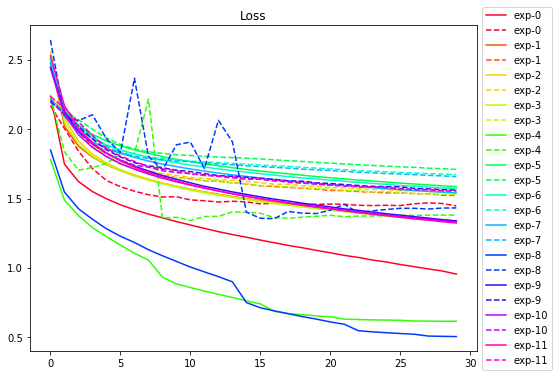

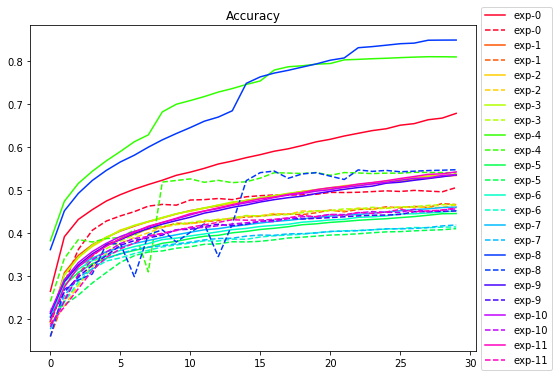

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()